In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_core

In [2]:
from langchain_openai import ChatOpenAI
from google.colab import userdata

# Create an instance of LLM of your choice
llm = ChatOpenAI(model="gpt-4o-mini", api_key=userdata.get('OPENAI_API_KEY'),
                      temperature=0)

In [4]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage

# System message for Conversational Agent
sys_msg_conversation = SystemMessage(content="""

  Role: You are the Conversation Coordinator for a hotel chain’s customer support system. Your role is to manage the flow of the conversation with the guest and decide whether to handle the request yourself or route the conversation to a specialized agent based on the user’s needs.

  Primary Tasks:

  Engage with the user: Start the conversation politely and ask how you can assist them.
  Identify the nature of the request: Listen to the guest’s inquiry and determine if it’s a general question, booking-related, issue resolution, or any other category that might require specialized handling.
  Maintain a friendly and helpful tone: Always aim for a customer-friendly and empathetic response. Ensure the guest feels heard and cared for, regardless of whether they are routed to another agent or assisted by you.

   """)

# Agent node
def conv_assistant(state: MessagesState) -> MessagesState:
  """
  Conversation Assistant Agent

  Args:
    state (MessagesState): The current state of the conversation.

  Returns:
    MessagesState: The updated state of the conversation.
  """
  messages = state["messages"]
  return {"messages": [llm.invoke([sys_msg_conversation] + messages)]}

In [5]:
from langgraph.graph import START, END, StateGraph

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("conv_assistant", conv_assistant)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "conv_assistant")
builder.add_edge("conv_assistant", END)
react_graph = builder.compile()

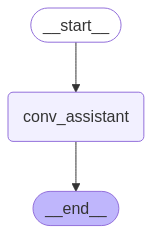

In [7]:
# Draw the graph
from IPython.display import Image, display
png = react_graph.get_graph().draw_mermaid_png()
display(Image(png))


In [8]:
from langchain_core.messages import HumanMessage

# user input
query="Hello, I want to book a room in your hotel!"

# call the graph with the input
events = react_graph.stream(
     {"messages": [HumanMessage(content=query)]}, stream_mode="values",
)

# iterate over the messages
for event in events:
   event["messages"][-1].pretty_print()
   message_content= event["messages"][-1].content
   if "Answer:" in message_content:
      final_answer=message_content.split("Answer:",1)[1].strip()

================================ Human Message =================================

Hello, I want to book a room in your hotel!
================================== Ai Message ==================================

Hello! Thank you for reaching out. I’d be happy to help you with your room booking. Could you please provide me with the following details?

1. The location of the hotel you’re interested in.
2. Your check-in and check-out dates.
3. The number of guests and any specific room preferences you may have.

Once I have that information, I can assist you further!


In [9]:
# user input
query="From 12 of June till 27 of June"

# call the graph with the input
events = react_graph.stream(
     {"messages": [HumanMessage(content=query)]}, stream_mode="values",
)

# iterate over the messages
for event in events:
   event["messages"][-1].pretty_print()
   message_content= event["messages"][-1].content
   if "Answer:" in message_content:
      final_answer=message_content.split("Answer:",1)[1].strip()

================================ Human Message =================================

From 12 of June till 27 of June
================================== Ai Message ==================================

Hello! Thank you for reaching out. It seems like you might be referring to dates for a booking or an inquiry related to those dates. How can I assist you with this? Are you looking to make a reservation, check availability, or something else?


In [10]:
from langgraph.checkpoint.memory import MemorySaver

# initialize the memory saver
memory = MemorySaver()

# add the memory saver to the graph as a checkpointer
react_graph_with_memory = builder.compile(checkpointer=memory)

In [11]:
thread_id = 42  # Replace with the actual thread ID

# Example usage:
query = "I need a room with a view."

events = react_graph_with_memory.stream({"messages": [HumanMessage(content=query)]},
                                        config={"thread_id": thread_id},  # Pass the thread_id here
                                        stream_mode="values")

# iterate over the messages
for event in events:
    event["messages"][-1].pretty_print()
    message_content = event["messages"][-1].content
    if "Answer:" in message_content:
        final_answer = message_content.split("Answer:", 1)[1].strip()


================================ Human Message =================================

I need a room with a view.
================================== Ai Message ==================================

Hello! Thank you for reaching out. I’d be happy to help you with your request for a room with a view. Could you please provide me with the location of the hotel you’re interested in and the dates of your stay? This will help me assist you better!


In [12]:
query = "New York"

events = react_graph_with_memory.stream({"messages": [HumanMessage(content=query)]},
                                        config={"thread_id": thread_id},  # Pass the thread_id here
                                        stream_mode="values")
# iterate over the messages
for event in events:
    event["messages"][-1].pretty_print()
    message_content = event["messages"][-1].content
    if "Answer:" in message_content:
        final_answer = message_content.split("Answer:", 1)[1].strip()

================================ Human Message =================================

New York
================================== Ai Message ==================================

Great choice! New York has some fantastic views. Could you please let me know the dates you plan to stay? Additionally, if you have any specific preferences for the type of view (like a city skyline, river, or park), feel free to share!


In [ ]:
# let's put everything in a chat format

thread_id = 4242

def chat_with_agent(react_graph_with_memory, thread_id):
  """
  Chat with the agent.

  Args:
    react_graph_with_memory (): The graph with the agent.
    thread_id (int): The ID of the thread.
  """
  while True:
      user_input = input("You: ")
      if user_input.lower() in ["quit", "exit"]:
          break

      events = react_graph_with_memory.stream(
          input={"messages": [HumanMessage(content=user_input)]},
          config={"thread_id": thread_id},
          stream_mode="values",
      )

      for event in events:
          event["messages"][-1].pretty_print()
          message_content = event["messages"][-1].content
          if "Answer:" in message_content:
              final_answer = message_content.split("Answer:", 1)[1].strip()
              print(f"Agent: {final_answer}")

chat_with_agent(react_graph_with_memory, thread_id)


================================ Human Message =================================

Hey
================================== Ai Message ==================================

Hello! Welcome to our hotel support. How can I assist you today?
================================ Human Message =================================

I want to book a room in your hotel
================================== Ai Message ==================================

Great! I can help you with that. Could you please provide me with the following details?

1. Check-in and check-out dates
2. Number of guests
3. Any specific room preferences or requirements?

Once I have that information, I can assist you further!
================================ Human Message =================================

Single room, for today
================================== Ai Message ==================================

Thank you for the information! Just to confirm, you would like to book a single room for today. Could you please let me know your c